# ***Clone Repo***

In [ ]:
!git clone https://github.com/ej0cl6/deep-active-learning.git

Cloning into 'deep-active-learning'...
remote: Enumerating objects: 232, done.
remote: Total 232 (delta 0), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (232/232), 44.12 KiB | 14.71 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [ ]:
%cd deep-active-learning

/content/deep-active-learning


# ***Modifying on Code***

In [ ]:
%%writefile data.py
import numpy as np
import torch
from torchvision import datasets

class Data:
    def __init__(self, X_train, Y_train, X_test, Y_test, handler):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.handler = handler
        
        self.n_pool = len(X_train)
        self.n_test = len(X_test)
        
        self.labeled_idxs = np.zeros(self.n_pool, dtype=bool)
        
    def initialize_labels(self, num):
        # generate initial labeled pool
        tmp_idxs = np.arange(self.n_pool)
        np.random.shuffle(tmp_idxs)
        self.labeled_idxs[tmp_idxs[:num]] = True
    
    def get_labeled_data(self):
        labeled_idxs = np.arange(self.n_pool)[self.labeled_idxs]
        return labeled_idxs, self.handler(self.X_train[labeled_idxs], self.Y_train[labeled_idxs])
    
    def get_unlabeled_data(self):
        unlabeled_idxs = np.arange(self.n_pool)[~self.labeled_idxs]
        return unlabeled_idxs, self.handler(self.X_train[unlabeled_idxs], self.Y_train[unlabeled_idxs])
    
    def get_train_data(self):
        return self.labeled_idxs.copy(), self.handler(self.X_train, self.Y_train)
    
    def cal_train_acc(self, train_preds):
        return 1.0 * (self.Y_train==train_preds).sum().item() / self.n_pool

   ###def cal_train_accuracy(self,preds):
        ##Y_labeled=self.Y_train[self.labeled_idxs]
        ###return 1.0 * (self.Y_labeled==preds).sum().item() / len(Y_labeled)


        
    def get_test_data(self):
        return self.handler(self.X_test, self.Y_test)
    
    def cal_test_acc(self, preds):
        return 1.0 * (self.Y_test==preds).sum().item() / self.n_test

def get_MNIST(handler):
    raw_train = datasets.MNIST('./data/MNIST', train=True, download=True)
    raw_test = datasets.MNIST('./data/MNIST', train=False, download=True)
    return Data(raw_train.data[:40000], raw_train.targets[:40000], raw_test.data[:40000], raw_test.targets[:40000], handler)

def get_FashionMNIST(handler):
    raw_train = datasets.FashionMNIST('./data/FashionMNIST', train=True, download=True)
    raw_test = datasets.FashionMNIST('./data/FashionMNIST', train=False, download=True)
    return Data(raw_train.data[:40000], raw_train.targets[:40000], raw_test.data[:40000], raw_test.targets[:40000], handler)

def get_SVHN(handler):
    data_train = datasets.SVHN('./data/SVHN', split='train', download=True)
    data_test = datasets.SVHN('./data/SVHN', split='test', download=True)
    return Data(data_train.data[:40000], torch.from_numpy(data_train.labels)[:40000], data_test.data[:40000], torch.from_numpy(data_test.labels)[:40000], handler)

def get_CIFAR10(handler):
    data_train = datasets.CIFAR10('./data/CIFAR10', train=True, download=True)
    data_test = datasets.CIFAR10('./data/CIFAR10', train=False, download=True)
    return Data(data_train.data[:40000], torch.LongTensor(data_train.targets)[:40000], data_test.data[:40000], torch.LongTensor(data_test.targets)[:40000], handler)


Overwriting data.py


In [ ]:
%%writefile demo.py
import argparse
import numpy as np
import torch
from utils import get_dataset, get_net, get_strategy
from pprint import pprint

parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=1, help="random seed")
parser.add_argument('--n_init_labeled', type=int, default=10000, help="number of init labeled samples")
parser.add_argument('--n_query', type=int, default=1000, help="number of queries per round")
parser.add_argument('--n_round', type=int, default=10, help="number of rounds")
parser.add_argument('--dataset_name', type=str, default="MNIST", choices=["MNIST", "FashionMNIST", "SVHN", "CIFAR10"], help="dataset")
parser.add_argument('--strategy_name', type=str, default="RandomSampling", 
                    choices=["RandomSampling", 
                             "LeastConfidence", 
                             "MarginSampling", 
                             "EntropySampling", 
                             "LeastConfidenceDropout", 
                             "MarginSamplingDropout", 
                             "EntropySamplingDropout", 
                             "KMeansSampling",
                             "KCenterGreedy", 
                             "BALDDropout", 
                             "AdversarialBIM", 
                             "AdversarialDeepFool"], help="query strategy")
args = parser.parse_args()
pprint(vars(args))
print()

# fix random seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.enabled = False

# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dataset = get_dataset(args.dataset_name)                   # load dataset
net = get_net(args.dataset_name, device)                   # load network
strategy = get_strategy(args.strategy_name)(dataset, net)  # load strategy

# start experiment
dataset.initialize_labels(args.n_init_labeled)
print(f"number of labeled pool: {args.n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool-args.n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()



# round 0 accuracy
print("Round 0")
strategy.train()
preds = strategy.predict(dataset.get_test_data())
test_acc = dataset.cal_test_acc(preds)
_,y=dataset.get_train_data()
zk=strategy.predict(y)
train_acc=dataset.cal_train_acc(zk)
print(f"Round 0 testing accuracy: {test_acc}")
print(f"Round 0 training accuracy: {train_acc}")

# store results in a dictionary
results_test = {'strategy_name': args.strategy_name,
           'dataset_name': args.dataset_name,
           'n_init_labeled': args.n_init_labeled,
           'n_query': args.n_query,
           'n_round': args.n_round,
           'test_acc_0': test_acc,
           'test_acc': []}

# store results in a dictionary
results_train = {'strategy_name': args.strategy_name,
           'dataset_name': args.dataset_name,
           'n_init_labeled': args.n_init_labeled,
           'n_query': args.n_query,
           'n_round': args.n_round,
           'train_0': train_acc,
           'train_acc': []}

for rd in range(1, args.n_round+1):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(args.n_query)

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate  test accuracy
    preds = strategy.predict(dataset.get_test_data())
    test_acc = dataset.cal_test_acc(preds)
    results_test['test_acc'].append(test_acc)
    print(f"Round {rd} testing accuracy: {test_acc}")

    # calculate  train  accuracy
    _,y=dataset.get_train_data()
    zk=strategy.predict(y)
    train_acc=dataset.cal_train_acc(zk)
    results_train['train_acc'].append(train_acc)
    print(f"Round {rd} training accuracy: {train_acc}")

# print results dictionary
print(results_train)
print(results_test)

Overwriting demo.py


# ***CIFAR10 Dataset***

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name CIFAR10 --strategy_name RandomSampling

{'dataset_name': 'CIFAR10',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'RandomSampling'}

Files already downloaded and verified
Files already downloaded and verified
number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.38it/s]
Round 0 testing accuracy: 0.1098
Round 0 training accuracy: 0.10875
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.09it/s]
Round 1 testing accuracy: 0.1514
Round 1 training accuracy: 0.147575
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.36it/s]
Round 2 testing accuracy: 0.2546
Round 2 training accuracy: 0.252425
Round 3
100%|███████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]
Round 3 testing accuracy: 0.2561
Round 3 training accuracy:

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name CIFAR10 --strategy_name LeastConfidence

{'dataset_name': 'CIFAR10',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'LeastConfidence'}

Files already downloaded and verified
Files already downloaded and verified
number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.45it/s]
Round 0 testing accuracy: 0.1098
Round 0 training accuracy: 0.10875
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.12it/s]
Round 1 testing accuracy: 0.1582
Round 1 training accuracy: 0.1541
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.57it/s]
Round 2 testing accuracy: 0.1711
Round 2 training accuracy: 0.166225
Round 3
100%|███████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.86it/s]
Round 3 testing accuracy: 0.2011
Round 3 training accuracy: 

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name CIFAR10 --strategy_name EntropySampling

{'dataset_name': 'CIFAR10',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'EntropySampling'}

Files already downloaded and verified
Files already downloaded and verified
number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.00it/s]
Round 0 testing accuracy: 0.1098
Round 0 training accuracy: 0.10875
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.00it/s]
Round 1 testing accuracy: 0.1569
Round 1 training accuracy: 0.152525
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.67it/s]
Round 2 testing accuracy: 0.1281
Round 2 training accuracy: 0.127375
Round 3
100%|███████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]
Round 3 testing accuracy: 0.1794
Round 3 training accuracy

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name CIFAR10 --strategy_name MarginSampling

{'dataset_name': 'CIFAR10',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'MarginSampling'}

100% 170498071/170498071 [00:12<00:00, 13313516.88it/s]
Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified
number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.49it/s]
Round 0 testing accuracy: 0.1098
Round 0 training accuracy: 0.10875
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.42it/s]
Round 1 testing accuracy: 0.1518
Round 1 training accuracy: 0.14855
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.07it/s]
Round 2 testing accuracy: 0.196
Round 2 training accuracy: 0.19
Round 3
100%|███████████████████████████████████████████████████████████████| 20/20 [00:0

# ***Plot Training Accuracy***

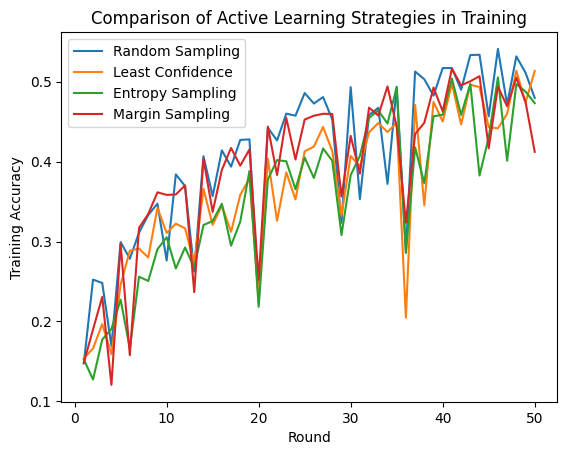

In [ ]:
import matplotlib.pyplot as plt

result_RS_train= [0.147575, 0.252425, 0.248225, 0.169225, 0.299375, 0.278525, 0.311275, 0.3332, 0.3475, 0.27635, 0.384075, 0.369475, 0.2625, 0.4068, 0.356875, 0.414125, 0.39375, 0.427225, 0.42785, 0.2237,
                  0.4424, 0.426575, 0.460125, 0.4575, 0.485875, 0.472725, 0.480825, 0.452725, 0.3236, 0.493225,0.3531, 0.4585, 0.46735, 0.372175, 0.493675,0.28655, 0.512775, 
                  0.5031, 0.48265, 0.517125, 0.517125, 0.489925, 0.533425, 0.5338, 0.456825, 0.541075, 0.47145, 0.531725, 0.511275, 0.479775]
result_LC_train=[0.1541, 0.166225, 0.19675, 0.159125, 0.2463, 0.28865, 0.2912, 0.28015, 0.3421, 0.310775, 0.322375, 0.316625, 0.2729, 0.365875, 0.320875, 0.345025, 0.3122, 0.3584, 0.379075, 0.227725,
                 0.403725, 0.326, 0.386625, 0.35275, 0.412925, 0.418825, 0.4434, 0.4132, 0.332125, 0.407225, 0.393725, 0.4369, 0.448275, 0.437, 0.4488, 0.2048, 0.47115, 0.34545,
                 0.474725, 0.450225, 0.497825, 0.44655, 0.4963, 0.493275, 0.443175, 0.44175, 0.459825, 0.513675, 0.47375, 0.513575]
result_E_train=[0.152525, 0.127375, 0.1773, 0.1908, 0.2273, 0.1661, 0.25605, 0.250725, 0.290375, 0.305425, 0.26635, 0.2926, 0.2675, 0.32065, 0.325725, 0.347375, 0.294925, 0.324975, 0.388275, 0.218375, 
                0.377775, 0.401975, 0.400425, 0.3655, 0.4051, 0.379625, 0.416475, 0.401025, 0.308125, 0.383225, 0.40715, 0.45495, 0.464075, 0.4477, 0.493125, 0.285775, 0.4179, 0.37295,
                0.45685, 0.4587, 0.504, 0.45845, 0.49755, 0.382675, 0.430375, 0.5055, 0.401175, 0.49705, 0.487725, 0.47315]
result_M_train=[0.14855, 0.19, 0.2308, 0.120625, 0.296725, 0.157775, 0.317175, 0.334475, 0.361625, 0.3584, 0.358925, 0.3702, 0.236775, 0.403575, 0.3371, 0.3897, 0.41715, 0.395, 0.41525, 0.251725, 0.443875,
                0.38325, 0.4547, 0.4027, 0.452675, 0.4575, 0.459875, 0.4597, 0.35635, 0.432225, 0.385025, 0.467625, 0.457725, 0.49415, 0.443625, 0.323675, 0.43455, 0.448625, 0.492725, 
                0.463075, 0.516275, 0.49555, 0.5006, 0.50695, 0.41675, 0.493875, 0.4693, 0.5051, 0.47475, 0.412325]

x = range(1, len(result_LC_train) + 1)

plt.plot(x, result_RS_train, label='Random Sampling')
plt.plot(x, result_LC_train, label='Least Confidence')
plt.plot(x, result_E_train, label='Entropy Sampling')
plt.plot(x, result_M_train, label='Margin Sampling')

plt.xlabel('Round')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Active Learning Strategies in Training')
plt.legend()
plt.show()

# ***Plot Testing Accuracy***

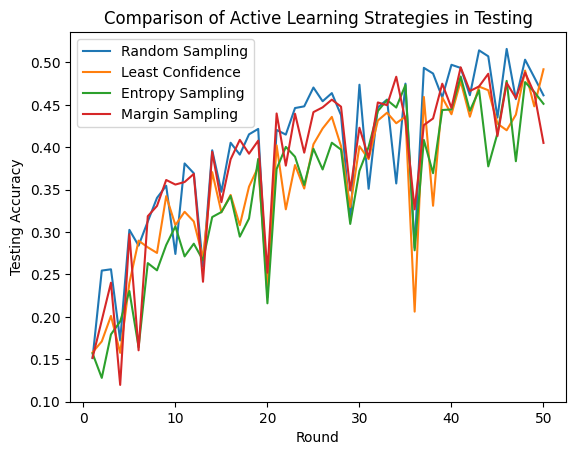

In [ ]:
import matplotlib.pyplot as plt

result_RS_test= [0.1514, 0.2546, 0.2561, 0.1722, 0.3026, 0.284, 0.3125, 0.3403, 0.3546, 0.2742, 0.3809, 0.3693, 0.2592, 0.3964, 0.3475, 0.4053, 0.3913, 
                 0.4152, 0.4216, 0.2233, 0.4204, 0.4149, 0.4462, 0.4482, 0.4704, 0.4542, 0.4638, 0.4378, 0.3138, 0.4737, 0.351, 0.4469, 0.4562, 0.3573,
                 0.475, 0.2814, 0.4936, 0.4869, 0.4587, 0.4972, 0.4935, 0.4613, 0.5142, 0.5072, 0.4349, 0.5159, 0.4567, 0.5032, 0.4824, 0.4612]
result_LC_test=[0.1582, 0.1711, 0.2011, 0.1576, 0.24, 0.2899, 0.282, 0.2754, 0.3424, 0.3082, 0.3239, 0.3125, 0.2695, 0.3706, 0.3233, 0.3438, 0.3081, 0.3535,
                0.3769, 0.2335, 0.4022, 0.3268, 0.379, 0.3513, 0.4035, 0.4221, 0.4358, 0.4013, 0.3294, 0.4012, 0.386, 0.4315, 0.4407, 0.4283, 0.4362, 0.2062,
                0.4593, 0.331, 0.4586, 0.4389, 0.4778, 0.436, 0.4715, 0.4672, 0.4278, 0.42, 0.4384, 0.4904, 0.4482, 0.4919]
result_E_test=[0.1569, 0.1281, 0.1794, 0.1946, 0.2305, 0.1643, 0.2634, 0.2549, 0.2847, 0.3067, 0.2713, 0.2863, 0.2668, 0.3177, 0.3236, 0.3425, 0.2946, 0.3159,
               0.3862, 0.216, 0.3744, 0.4004, 0.3888, 0.3555, 0.3982, 0.3738, 0.4053, 0.3972, 0.3096, 0.3722, 0.4004, 0.4427, 0.4557, 0.4468, 0.4734, 0.2785,
               0.4086, 0.3694, 0.4439, 0.4445, 0.4834, 0.4429, 0.4672, 0.3774, 0.4164, 0.4782, 0.3835, 0.4768, 0.4652, 0.4512]
result_M_test=[0.1518, 0.196, 0.2403, 0.1198, 0.2974, 0.1606, 0.3187, 0.3308, 0.3614, 0.356, 0.359, 0.3685, 0.2414, 0.3946, 0.3352, 0.3857, 0.4087, 0.3924,
               0.4078, 0.2521, 0.4398, 0.3783, 0.4395, 0.3936, 0.4414, 0.447, 0.4561, 0.4478, 0.349, 0.423, 0.3877, 0.4528, 0.4496, 0.4831, 0.4314, 0.3268,
               0.4261, 0.4339, 0.4749, 0.4464, 0.4942, 0.4662, 0.4717, 0.4866, 0.4132, 0.4758, 0.458, 0.488, 0.4636, 0.4051]

x = range(1, len(result_LC_test) + 1)

plt.plot(x, result_RS_test, label='Random Sampling')
plt.plot(x, result_LC_test, label='Least Confidence')
plt.plot(x, result_E_test, label='Entropy Sampling')
plt.plot(x, result_M_test, label='Margin Sampling')

plt.xlabel('Round')
plt.ylabel('Testing Accuracy')
plt.title('Comparison of Active Learning Strategies in Testing')
plt.legend()
plt.show()


# ***MNIST Dataset***

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name MNIST --strategy_name RandomSampling

{'dataset_name': 'MNIST',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'RandomSampling'}

100% 9912422/9912422 [00:00<00:00, 422560333.82it/s]
Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

100% 28881/28881 [00:00<00:00, 166624063.03it/s]
Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

100% 1648877/1648877 [00:00<00:00, 226394245.01it/s]
Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

100% 4542/4542 [00:00<00:00, 42147187.54it/s]
Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]
Round 0 testing accuracy: 0.1266
Round 0 training accuracy: 0.12845
Round 1
100%|██████████████████████████████████████

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name MNIST --strategy_name LeastConfidence

{'dataset_name': 'MNIST',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'LeastConfidence'}

100% 9912422/9912422 [00:00<00:00, 430698027.00it/s]
Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

100% 28881/28881 [00:00<00:00, 192278879.09it/s]
Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

100% 1648877/1648877 [00:00<00:00, 237178620.55it/s]
Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

100% 4542/4542 [00:00<00:00, 38642046.18it/s]
Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.48it/s]
Round 0 testing accuracy: 0.1266
Round 0 training accuracy: 0.12845
Round 1
100%|█████████████████████████████████████

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name MNIST --strategy_name EntropySampling

{'dataset_name': 'MNIST',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'EntropySampling'}

number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]
Round 0 testing accuracy: 0.1266
Round 0 training accuracy: 0.12845
Round 1
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]
Round 1 testing accuracy: 0.1029
Round 1 training accuracy: 0.104125
Round 2
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.59it/s]
Round 2 testing accuracy: 0.1206
Round 2 training accuracy: 0.12155
Round 3
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]
Round 3 testing accuracy: 0.2633
Round 3 training accuracy: 0.25875
Round 4
100%|████████████████████████████████████████████████████████

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name MNIST --strategy_name MarginSampling

{'dataset_name': 'MNIST',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'MarginSampling'}

number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]
Round 0 testing accuracy: 0.1266
Round 0 training accuracy: 0.12845
Round 1
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]
Round 1 testing accuracy: 0.1058
Round 1 training accuracy: 0.107625
Round 2
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.69it/s]
Round 2 testing accuracy: 0.1254
Round 2 training accuracy: 0.12895
Round 3
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]
Round 3 testing accuracy: 0.2233
Round 3 training accuracy: 0.22395
Round 4
100%|█████████████████████████████████████████████████████████

# ***Plot Training Accuracy***

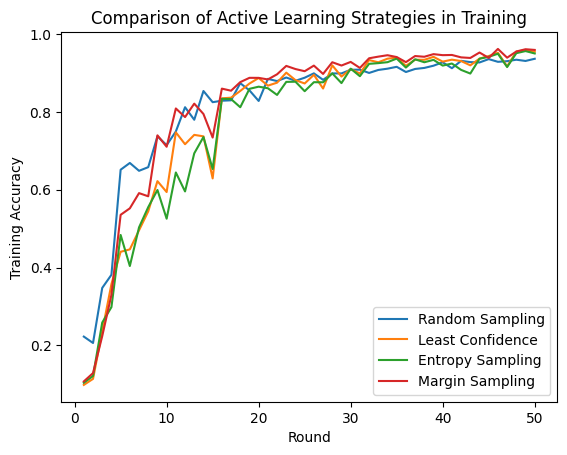

In [ ]:
import matplotlib.pyplot as plt

result_RS_train=[0.222675, 0.206275, 0.347725, 0.38145, 0.651325, 0.6687, 0.648525, 0.657925, 0.737125, 0.714425, 0.74955, 0.811875, 0.77965, 0.853525, 0.8248, 0.82855,0.829625, 0.873575,
                 0.855125, 0.82795, 0.8847, 0.879, 0.888175, 0.8797, 0.88765, 0.89885, 0.8822, 0.8987, 0.8987, 0.9081, 0.908275, 0.899925, 0.907575,0.91085, 0.91565, 0.9023, 0.910125, 
                 0.912775, 0.9185, 0.92725, 0.912025, 0.931, 0.927725, 0.92685, 0.93545, 0.928475, 0.9301, 0.9339, 0.9307, 0.936325]
result_LC_train=[0.098575, 0.114075, 0.23635, 0.35755, 0.44055, 0.446725, 0.495725, 0.544425, 0.622, 0.593975, 0.747275, 0.716825, 0.740825, 0.737075, 0.629, 0.834675, 0.83635, 0.85365,
                 0.8727, 0.88695, 0.867275, 0.8749, 0.90065, 0.881375, 0.872875, 0.895025, 0.85985, 0.91945, 0.8906, 0.9099, 0.89845, 0.933, 0.92725, 0.9365, 0.9395, 0.9182, 0.93395, 
                 0.9336, 0.941225, 0.92895, 0.934, 0.930475, 0.919425, 0.93675, 0.943325, 0.951675, 0.916725, 0.9548, 0.9584, 0.95455]
result_E_train=[0.104125, 0.12155, 0.25875, 0.2984, 0.48375, 0.403975, 0.50325, 0.555225, 0.599275, 0.525475, 0.64425, 0.595575, 0.6934, 0.735325, 0.6531, 0.833375, 0.832725, 0.8118, 
                0.859125, 0.864625, 0.860625, 0.843425, 0.876925, 0.877375, 0.853025, 0.87615, 0.87585, 0.8988, 0.8738, 0.9109, 0.891575, 0.9233, 0.9251, 0.92755, 0.93675, 0.91375, 
                0.934875, 0.92735, 0.9335, 0.918725, 0.924075, 0.907725, 0.898325, 0.936375, 0.941325, 0.9492, 0.915025, 0.950675, 0.9561, 0.949925]
result_M_train=[0.107625, 0.12895, 0.22395, 0.3298, 0.5355, 0.552125, 0.591225, 0.58305, 0.739625, 0.710325, 0.808675, 0.78655, 0.821075, 0.794475, 0.733925, 0.859625, 0.85425, 
                0.87635, 0.88735, 0.88725, 0.8832, 0.896425, 0.917975, 0.9099, 0.90435, 0.91875, 0.897375, 0.927375, 0.91895, 0.92825, 0.912775, 0.937575, 0.941775, 0.945425, 
                0.940725, 0.92765, 0.943325, 0.941475, 0.9482, 0.945575, 0.946075, 0.9399, 0.9384, 0.95235, 0.938525, 0.9616, 0.939075, 0.955, 0.9608, 0.959025]

x = range(1, len(result_LC_train) + 1)

plt.plot(x, result_RS_train, label='Random Sampling')
plt.plot(x, result_LC_train, label='Least Confidence')
plt.plot(x, result_E_train, label='Entropy Sampling')
plt.plot(x, result_M_train, label='Margin Sampling')

plt.xlabel('Round')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Active Learning Strategies in Training')
plt.legend()
plt.show()


# ***Plot Testing Accuracy***

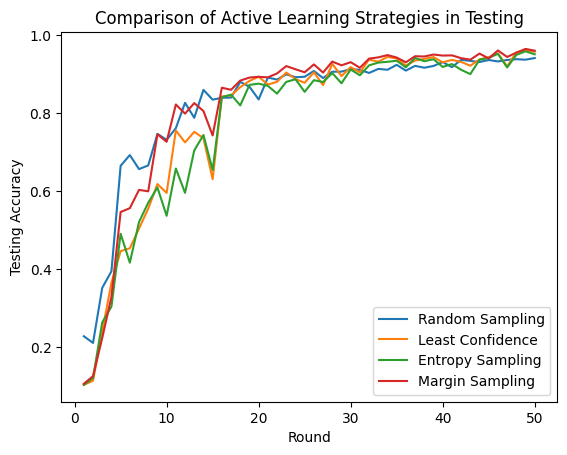

In [ ]:
import matplotlib.pyplot as plt

result_RS_test=[0.2278, 0.2106, 0.3518, 0.3942, 0.6648, 0.6922, 0.6562, 0.6658, 0.7466, 0.7312, 0.7612, 0.8262, 0.7878, 0.8594, 0.8343, 0.8391, 0.8397, 0.88, 
                0.8674, 0.8349, 0.8909, 0.8858, 0.8993, 0.8919, 0.893, 0.9079, 0.8896, 0.906, 0.9061, 0.9127, 0.9106, 0.9028, 0.9132, 0.911, 0.9236, 0.9088,
                0.921, 0.9162, 0.9207, 0.9308, 0.9176, 0.9364, 0.9337, 0.9308, 0.936, 0.9323, 0.9361, 0.9381, 0.9368, 0.941]
result_LC_test=[0.1032, 0.1135, 0.2397, 0.3647, 0.446, 0.4532, 0.5039, 0.5549, 0.6179, 0.5952, 0.7553, 0.7247, 0.7518, 0.7356, 0.6304, 0.8426, 0.845, 0.8665, 0.8823,
                0.8931, 0.873, 0.88, 0.9039, 0.8872, 0.8776, 0.9045, 0.8715, 0.9259, 0.8948, 0.9177, 0.9043, 0.9372, 0.9315, 0.944, 0.9397, 0.9218, 0.9345, 0.939, 
                0.9435, 0.93, 0.9363, 0.9311, 0.9213, 0.9376, 0.9431, 0.953, 0.9196, 0.9555, 0.9608, 0.9574]
result_E_test= [0.1029, 0.1206, 0.2633, 0.3038, 0.4904, 0.4163, 0.5207, 0.5701, 0.609, 0.5365, 0.6577, 0.5953, 0.7042, 0.7437, 0.6537, 0.8406, 0.847, 0.8196, 0.8722,
                0.8754, 0.8696, 0.8499, 0.8799, 0.8866, 0.8543, 0.8842, 0.8795, 0.9024, 0.8763, 0.9116, 0.8968, 0.9223, 0.9293, 0.9314, 0.9341, 0.9173, 0.9412, 0.9329,
                0.938, 0.9182, 0.9256, 0.9109, 0.8998, 0.9366, 0.9414, 0.9519, 0.9169, 0.949, 0.9583, 0.9507]
result_M_test=[0.1058, 0.1254, 0.2233, 0.3285, 0.5462, 0.5561, 0.603, 0.5992, 0.7456, 0.7263, 0.8219, 0.7985, 0.8255, 0.8051, 0.7425, 0.8649, 0.8596, 0.8832, 0.891, 
               0.8929, 0.8915, 0.9016, 0.9204, 0.9122, 0.9045, 0.9247, 0.9038, 0.932, 0.9224, 0.9304, 0.916, 0.9396, 0.9427, 0.9486, 0.9423, 0.9301, 0.9457, 0.945, 
               0.95, 0.9473, 0.9479, 0.9407, 0.9368, 0.9525, 0.9399, 0.9605, 0.9438, 0.9548, 0.9644, 0.9599]

x = range(1, len(result_LC_test) + 1)

plt.plot(x, result_RS_test, label='Random Sampling')
plt.plot(x, result_LC_test, label='Least Confidence')
plt.plot(x, result_E_test, label='Entropy Sampling')
plt.plot(x, result_M_test, label='Margin Sampling')

plt.xlabel('Round')
plt.ylabel('Testing Accuracy')
plt.title('Comparison of Active Learning Strategies in Testing')
plt.legend()
plt.show()


# ***Fashion MNIST Dataset (Imbalanced Dataset)***

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name FashionMNIST --strategy_name RandomSampling

{'dataset_name': 'FashionMNIST',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'RandomSampling'}

100% 26421880/26421880 [00:01<00:00, 19754576.63it/s]
Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

100% 29515/29515 [00:00<00:00, 322416.93it/s]
Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

100% 4422102/4422102 [00:00<00:00, 6239568.03it/s]
Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

100% 5148/5148 [00:00<00:00, 28561212.95it/s]
Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]
Roun

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name FashionMNIST --strategy_name LeastConfidence

{'dataset_name': 'FashionMNIST',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'LeastConfidence'}

number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.29it/s]
Round 0 testing accuracy: 0.2053
Round 0 training accuracy: 0.2046
Round 1
100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.27it/s]
Round 1 testing accuracy: 0.1
Round 1 training accuracy: 0.0996
Round 2
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.48it/s]
Round 2 testing accuracy: 0.1
Round 2 training accuracy: 0.0996
Round 3
100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.79it/s]
Round 3 testing accuracy: 0.1362
Round 3 training accuracy: 0.1357
Round 4
100%|████████████████████████████████████████████████████████████

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name FashionMNIST --strategy_name EntropySampling

{'dataset_name': 'FashionMNIST',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'EntropySampling'}

100% 26421880/26421880 [00:03<00:00, 8502559.94it/s] 
Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

100% 29515/29515 [00:00<00:00, 143182.68it/s]
Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

100% 4422102/4422102 [00:01<00:00, 2730649.65it/s]
Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

100% 5148/5148 [00:00<00:00, 31068024.45it/s]
Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.76it/s]
Rou

In [ ]:
!python demo.py --n_round 50 --n_query 100 --n_init_labeled 50 --dataset_name FashionMNIST --strategy_name MarginSampling

{'dataset_name': 'FashionMNIST',
 'n_init_labeled': 50,
 'n_query': 100,
 'n_round': 50,
 'seed': 1,
 'strategy_name': 'MarginSampling'}

number of labeled pool: 50
number of unlabeled pool: 39950
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.80it/s]
Round 0 testing accuracy: 0.2053
Round 0 training accuracy: 0.2046
Round 1
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]
Round 1 testing accuracy: 0.2035
Round 1 training accuracy: 0.204975
Round 2
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.13it/s]
Round 2 testing accuracy: 0.1002
Round 2 training accuracy: 0.099825
Round 3
100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.64it/s]
Round 3 testing accuracy: 0.1633
Round 3 training accuracy: 0.16565
Round 4
100%|██████████████████████████████████████████████████

# ***Plot Training Accuracy***


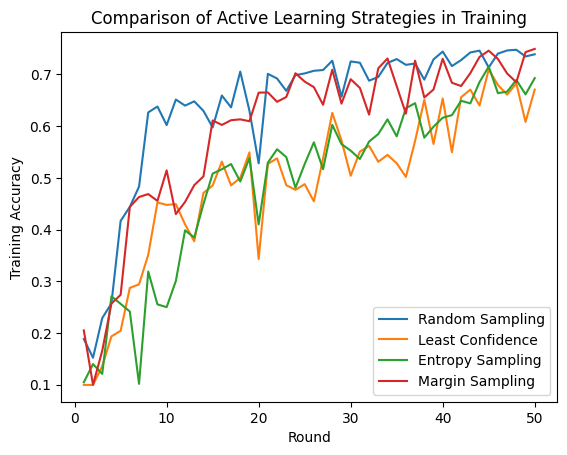

In [ ]:
import matplotlib.pyplot as plt

result_RS_train=[0.188325, 0.1522, 0.228725, 0.2572, 0.4167, 0.44385, 0.483, 0.62655, 0.63785, 0.602025, 0.651375, 0.63965, 0.647875, 0.62945, 0.597475, 0.659175, 0.636225, 0.70545, 0.6294,
                 0.52805, 0.701075, 0.69205, 0.66815, 0.698675, 0.701875, 0.706975, 0.70845, 0.7265, 0.656775, 0.7251, 0.7225, 0.6878, 0.695075, 0.722075, 0.729625, 0.718475, 0.721075,
                 0.689875, 0.729, 0.744125, 0.716075, 0.727675, 0.74245, 0.745925, 0.713425, 0.7402, 0.746275, 0.747625, 0.73465, 0.738875]

result_LC_train= [0.0996, 0.0996, 0.1357, 0.193475, 0.20425, 0.28715, 0.294, 0.351075, 0.452325, 0.447725, 0.449125, 0.41015, 0.37735, 0.47085, 0.485125, 0.531325, 0.485375, 0.499875, 
                  0.54925, 0.343125, 0.526975, 0.537675, 0.4858, 0.476775, 0.4878, 0.454525, 0.5377, 0.625625, 0.5723, 0.504, 0.550675, 0.561825, 0.531, 0.54435, 0.52815, 0.50175,
                  0.57125, 0.65085, 0.565475, 0.653425, 0.54955, 0.65585, 0.67055, 0.639875, 0.7094, 0.679475, 0.66085, 0.68245, 0.6081, 0.670725]

result_E_train=[0.104725, 0.1399, 0.120925, 0.2709, 0.256375, 0.241475, 0.10165, 0.31885, 0.255375, 0.249975, 0.300525, 0.398525, 0.38465, 0.449275, 0.50815, 0.51665, 0.526625, 0.4929,
                0.53825, 0.409925, 0.52935, 0.555275, 0.54015, 0.48085, 0.52655, 0.568675, 0.51675, 0.60235, 0.565175, 0.55255, 0.5364, 0.570175, 0.58465, 0.613025, 0.58015, 0.634625,
                0.644375, 0.57765, 0.59885, 0.616175, 0.621225, 0.649, 0.64395, 0.68505, 0.715125, 0.66375, 0.66665, 0.689225, 0.661425, 0.69275]

result_M_train=[0.204975, 0.099825, 0.16565, 0.256925, 0.27375, 0.4438, 0.462925, 0.4686, 0.45545, 0.51435, 0.42985, 0.45335, 0.4858, 0.5028, 0.611, 0.60225, 0.611425, 0.61305, 0.60945,
                0.664725, 0.665125, 0.647, 0.65625, 0.702225, 0.686025, 0.675375, 0.641225, 0.7091, 0.6435, 0.6907, 0.673825, 0.622175, 0.711775, 0.730725, 0.677275, 0.6241, 0.7266,
                0.65535, 0.6708, 0.7302, 0.683775, 0.67755, 0.702375, 0.733775, 0.7459, 0.7298, 0.701725, 0.684825, 0.7431, 0.74925]

x = range(1, len(result_LC_train) + 1)

plt.plot(x, result_RS_train, label='Random Sampling')
plt.plot(x, result_LC_train, label='Least Confidence')
plt.plot(x, result_E_train, label='Entropy Sampling')
plt.plot(x, result_M_train, label='Margin Sampling')

plt.xlabel('Round')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Active Learning Strategies in Training')
plt.legend()
plt.show()


# ***Plot Testing Accuracy***

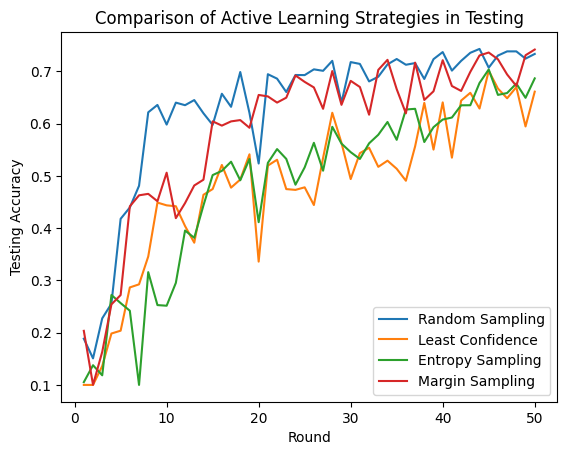

In [ ]:
import matplotlib.pyplot as plt

result_RS=[0.1885, 0.1508, 0.2274, 0.2555, 0.4179, 0.4396, 0.4811, 0.6218, 0.6359, 0.5983, 0.6403, 0.6354, 0.6452, 0.6199, 0.5977, 0.6573, 0.6323, 0.6989, 0.6206,
           0.5238, 0.6947, 0.6862, 0.6606, 0.6932, 0.693, 0.704, 0.7012, 0.7203, 0.6404, 0.7179, 0.7144, 0.6809, 0.6899, 0.7135, 0.7238, 0.7128, 0.716, 0.6856, 
           0.7235, 0.7371, 0.7016, 0.7202, 0.7357, 0.7431, 0.7072, 0.7304, 0.7384, 0.7384, 0.7245, 0.7335]

result_LC=[0.1, 0.1, 0.1362, 0.1984, 0.2038, 0.2866, 0.2925, 0.3458, 0.449, 0.4437, 0.442, 0.4041, 0.3722, 0.4639, 0.4749, 0.521, 0.4776, 0.4931, 0.5414, 0.336,
           0.5198, 0.531, 0.4748, 0.4733, 0.4782, 0.4443, 0.5345, 0.6209, 0.5632, 0.494, 0.5436, 0.5539, 0.5174, 0.5292, 0.5137, 0.4908, 0.5565, 0.6398, 0.5504, 
           0.6408, 0.535, 0.6442, 0.6591, 0.629, 0.7014, 0.6673, 0.6486, 0.67, 0.5947, 0.6613]

result_E=[0.1053, 0.1377, 0.1184, 0.2721, 0.2566, 0.242, 0.1, 0.3159, 0.2528, 0.2516, 0.2953, 0.3955, 0.3816, 0.4436, 0.5016, 0.5097, 0.5272, 0.4917, 0.5323,
          0.4115, 0.525, 0.5514, 0.5326, 0.4832, 0.5164, 0.5634, 0.51, 0.594, 0.5619, 0.5455, 0.5325, 0.5624, 0.5788, 0.6033, 0.5691, 0.6271, 0.6285, 0.5649,
          0.5933, 0.6079, 0.6118, 0.6352, 0.6353, 0.6779, 0.7038, 0.6551, 0.6587, 0.6768, 0.6495, 0.6867]

result_M=[0.2035, 0.1002, 0.1633, 0.2542, 0.272, 0.4418, 0.4629, 0.4657, 0.4516, 0.5062, 0.4192, 0.448, 0.4817, 0.4928, 0.6045, 0.5963, 0.6044, 0.6069, 0.5922,
          0.655, 0.6522, 0.6404, 0.6498, 0.6923, 0.68, 0.6694, 0.6285, 0.7007, 0.6361, 0.682, 0.6702, 0.6172, 0.703, 0.7222, 0.6661, 0.6198, 0.7169, 0.6454,
          0.662, 0.7215, 0.6721, 0.6627, 0.6992, 0.7306, 0.7362, 0.7233, 0.6942, 0.6722, 0.731, 0.7419]

x = range(1, len(result_LC) + 1)

plt.plot(x, result_RS, label='Random Sampling')
plt.plot(x, result_LC, label='Least Confidence')
plt.plot(x, result_E, label='Entropy Sampling')
plt.plot(x, result_M, label='Margin Sampling')

plt.xlabel('Round')
plt.ylabel('Testing Accuracy')
plt.title('Comparison of Active Learning Strategies in Testing')
plt.legend()
plt.show()

# ***SVHN Dataset***

In [ ]:
!python demo.py --n_round 60 --n_query 100 --n_init_labeled 150 --dataset_name SVHN --strategy_name RandomSampling

{'dataset_name': 'SVHN',
 'n_init_labeled': 150,
 'n_query': 100,
 'n_round': 60,
 'seed': 1,
 'strategy_name': 'RandomSampling'}

100% 182040794/182040794 [00:04<00:00, 43941139.97it/s]
100% 64275384/64275384 [00:02<00:00, 29104169.96it/s]
number of labeled pool: 150
number of unlabeled pool: 39850
number of testing pool: 26032

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.17it/s]
Round 0 testing accuracy: 0.15938076213890595
Round 0 training accuracy: 0.144375
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]
Round 1 testing accuracy: 0.15938076213890595
Round 1 training accuracy: 0.144375
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]
Round 2 testing accuracy: 0.15938076213890595
Round 2 training accuracy: 0.144375
Round 3
100%|███████████████████████████████████████████████████████████████| 20/20 [00:06<00:0

In [ ]:
!python demo.py --n_round 60 --n_query 100 --n_init_labeled 150 --dataset_name SVHN --strategy_name LeastConfidence

{'dataset_name': 'SVHN',
 'n_init_labeled': 150,
 'n_query': 100,
 'n_round': 60,
 'seed': 1,
 'strategy_name': 'LeastConfidence'}

Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
number of labeled pool: 150
number of unlabeled pool: 39850
number of testing pool: 26032

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.62it/s]
Round 0 testing accuracy: 0.15938076213890595
Round 0 training accuracy: 0.144375
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.49it/s]
Round 1 testing accuracy: 0.17144283958205286
Round 1 training accuracy: 0.15225
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]
Round 2 testing accuracy: 0.1958743085433313
Round 2 training accuracy: 0.188925
Round 3
100%|███████████████████████████████████████████████████████████████| 2

In [ ]:
!python demo.py --n_round 60 --n_query 100 --n_init_labeled 150 --dataset_name SVHN --strategy_name EntropySampling

{'dataset_name': 'SVHN',
 'n_init_labeled': 150,
 'n_query': 100,
 'n_round': 60,
 'seed': 1,
 'strategy_name': 'EntropySampling'}

Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
number of labeled pool: 150
number of unlabeled pool: 39850
number of testing pool: 26032

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.78it/s]
Round 0 testing accuracy: 0.15938076213890595
Round 0 training accuracy: 0.144375
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.61it/s]
Round 1 testing accuracy: 0.1958358942839582
Round 1 training accuracy: 0.188925
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.46it/s]
Round 2 testing accuracy: 0.1958743085433313
Round 2 training accuracy: 0.188925
Round 3
100%|███████████████████████████████████████████████████████████████| 2

In [ ]:
!python demo.py --n_round 60 --n_query 100 --n_init_labeled 150 --dataset_name SVHN --strategy_name MarginSampling

{'dataset_name': 'SVHN',
 'n_init_labeled': 150,
 'n_query': 100,
 'n_round': 60,
 'seed': 1,
 'strategy_name': 'MarginSampling'}

Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat
number of labeled pool: 150
number of unlabeled pool: 39850
number of testing pool: 26032

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.66it/s]
Round 0 testing accuracy: 0.15938076213890595
Round 0 training accuracy: 0.144375
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.36it/s]
Round 1 testing accuracy: 0.15938076213890595
Round 1 training accuracy: 0.144375
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.88it/s]
Round 2 testing accuracy: 0.1958743085433313
Round 2 training accuracy: 0.188925
Round 3
100%|███████████████████████████████████████████████████████████████| 2

# ***Plot Training Accuracy***

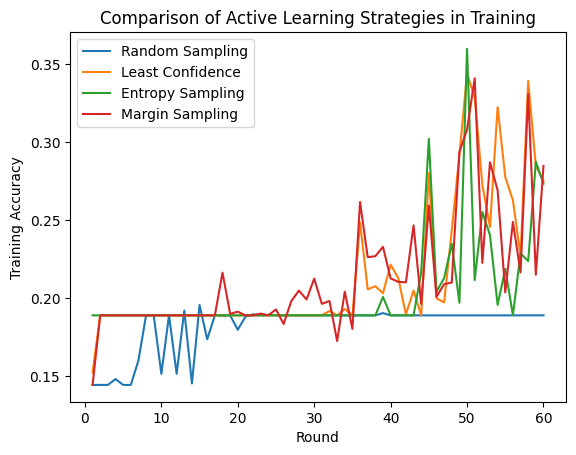

In [ ]:
import matplotlib.pyplot as plt
result_RS_train=[0.144375, 0.144375, 0.144375, 0.14815, 0.144375, 0.144375, 0.16, 0.188925, 0.188925, 0.15145, 0.188925, 0.1515, 0.192, 0.1453, 0.19555,
                 0.1736, 0.188925, 0.18875, 0.188925, 0.1797, 0.188075, 0.1896, 0.188925, 0.18925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 
                 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.190375, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925,
                 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.18895, 
                 0.188925, 0.18895]

result_LC_train=[0.15225, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925,
                 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925,
                 0.188925, 0.188925, 0.188925, 0.191725, 0.188925, 0.19295, 0.188925, 0.248525, 0.20555, 0.207625, 0.2031, 0.22135, 0.21275, 0.18955, 0.204825,
                 0.188925, 0.28, 0.199875, 0.1972, 0.2433, 0.291725, 0.3436, 0.328575, 0.2725, 0.24555, 0.32225, 0.2774, 0.26255, 0.227, 0.339075, 0.284625,
                 0.274875]

result_E_train=[0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925,
                0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925,
                0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.200725, 0.188925, 0.188925, 0.188925,
                0.188925, 0.21645, 0.302, 0.204, 0.212825, 0.234725, 0.197, 0.35955, 0.2115, 0.25515, 0.24025, 0.19565, 0.218675, 0.189075, 0.228675, 0.2237,
                0.287325, 0.273275]

result_M_train=[0.144375, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925, 0.188925,
                0.188925, 0.188925, 0.188925, 0.216275, 0.1899, 0.1913, 0.1889, 0.188925, 0.19005, 0.188925, 0.192725, 0.1834, 0.198075, 0.2048, 0.1991,
                0.212425, 0.1963, 0.1981, 0.17245, 0.2041, 0.18025, 0.26155, 0.2262, 0.2268, 0.2328, 0.2126, 0.210375, 0.2101, 0.24655, 0.196275, 0.25925,
                0.200775, 0.2089, 0.20995, 0.293575, 0.30795, 0.34075, 0.222575, 0.28695, 0.269025, 0.2036, 0.248775, 0.216425, 0.33075, 0.21495, 0.2846]

x = range(1, len(result_LC_train) + 1)

plt.plot(x, result_RS_train, label='Random Sampling')
plt.plot(x, result_LC_train, label='Least Confidence')
plt.plot(x, result_E_train, label='Entropy Sampling')
plt.plot(x, result_M_train, label='Margin Sampling')

plt.xlabel('Round')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Active Learning Strategies in Training')
plt.legend()
plt.show()


# ***Plot Testing Accuracy***

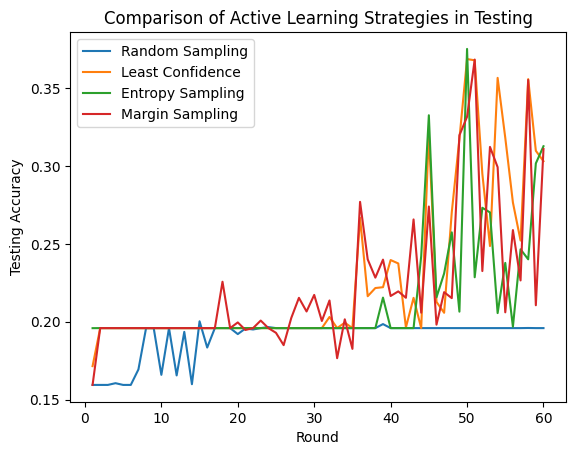

In [ ]:
import matplotlib.pyplot as plt
result_RS_test=[0.15938076213890595, 0.15938076213890595, 0.15938076213890595, 0.16049477566072526, 0.15938076213890595, 0.15938076213890595,
                0.1693300553165335, 0.1958743085433313, 0.1958743085433313, 0.16587277197295636, 0.1958743085433313, 0.16548862937922557, 0.1934542102028273,
                0.1598417332513829, 0.20025353411186234, 0.18338967424708053, 0.1958743085433313, 0.19591272280270436, 0.1958743085433313, 0.19203288260602336,
                0.19560540872771973, 0.19499078057775046, 0.1958743085433313, 0.19652735095267362, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1984480639213276, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.19595113706207745, 0.1958743085433313, 0.1958743085433313]

result_LC_test=[0.17144283958205286, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
                0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.20301936078672403, 0.1958743085433313, 0.1993700061462815, 0.1958743085433313,
                0.26671020282728947, 0.21634910878918254, 0.2216118623232944, 0.22214966195451752, 0.2395897357098955, 0.23740012292562998, 0.19633527965580824,
                0.21531192378610942, 0.1958743085433313, 0.32072065150583895, 0.2127381684081131, 0.2057083589428396, 0.27028272894898586, 0.3174938537185003,
                0.3686616472034419, 0.36789336201598033, 0.29502151198524895, 0.24857867240319606, 0.356599569760295, 0.3181084818684696, 0.27654425322679776,
                0.25211278426551936, 0.35579287031346035, 0.30977258758451137, 0.3030885064535956]

result_E_test=[0.1958358942839582, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
               0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
               0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
               0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
               0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
               0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.21546558082360173, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
               0.1958743085433313, 0.2420482483097726, 0.3325906576521205, 0.21561923786109405, 0.23098494161032576, 0.25737553779963124, 0.20643822987092808,
               0.3751920712968654, 0.22852642901044867, 0.2731637984019668, 0.2701674861708666, 0.20551628764597418, 0.2377458512599877, 0.1967578365089121,
               0.2465043023970498, 0.24005070682237248, 0.3016671788567916, 0.3126920712968654]

result_M_test=[0.15938076213890595, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
               0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.1958743085433313,
               0.1958743085433313, 0.1958743085433313, 0.1958743085433313, 0.22564535955746773, 0.1958743085433313, 0.19952366318377382, 0.19468346650276583,
               0.1958743085433313, 0.20071450522433928, 0.19591272280270436, 0.19283958205285803, 0.1849262446220037, 0.20240473263675476, 0.21531192378610942,
               0.20655347264904733, 0.21719422249539028, 0.20044560540872772, 0.2136216963736939, 0.1765519360786724, 0.20152120467117393, 0.18254456054087279,
               0.27696681007990165, 0.24001229256299939, 0.2282959434542102, 0.23985863552550707, 0.21650276582667485, 0.21946066379840196, 0.21535033804548248,
               0.2656730178242164, 0.20578518746158575, 0.27397049784880145, 0.19810233558696988, 0.21896127842655194, 0.215119852489244, 0.3197218807621389,
               0.3315918869084204, 0.3683543331284573, 0.23252151198524892, 0.3122695144437615, 0.2992470805162876, 0.20601567301782422, 0.2588352796558082,
               0.22649047326367547, 0.3552550706822373, 0.21054855562384758, 0.31088660110633065]

x = range(1, len(result_LC_test) + 1)

plt.plot(x, result_RS_test, label='Random Sampling')
plt.plot(x, result_LC_test, label='Least Confidence')
plt.plot(x, result_E_test, label='Entropy Sampling')
plt.plot(x, result_M_test, label='Margin Sampling')

plt.xlabel('Round')
plt.ylabel('Testing Accuracy')
plt.title('Comparison of Active Learning Strategies in Testing')
plt.legend()
plt.show()
